# Loading the required libraries

In [390]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from mlxtend.frequent_patterns import apriori, association_rules
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from math import ceil
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

## **Loading the dataset**

In [391]:
df = pd.read_csv("/content/data.csv")
df.shape

(541909, 8)

In [392]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [393]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


## **Data Cleaning**

In [394]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [395]:
df[df.Description.isnull()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,12/1/2010 14:32,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,12/1/2010 14:34,0.0,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
535322,581199,84581,NaN,-2,12/7/2011 18:26,0.0,NaN,United Kingdom
535326,581203,23406,NaN,15,12/7/2011 18:31,0.0,NaN,United Kingdom
535332,581209,21620,NaN,6,12/7/2011 18:35,0.0,NaN,United Kingdom
536981,581234,72817,NaN,27,12/8/2011 10:33,0.0,NaN,United Kingdom


In [396]:
df = df[df.Description.notnull()]

In [397]:
df[df.CustomerID.isnull()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom
1447,536544,21790,VINTAGE SNAP CARDS,9,12/1/2010 14:32,1.66,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,12/9/2011 10:26,4.13,NaN,United Kingdom
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,12/9/2011 10:26,4.13,NaN,United Kingdom
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,12/9/2011 10:26,4.96,NaN,United Kingdom
541539,581498,85174,S/4 CACTI CANDLES,1,12/9/2011 10:26,10.79,NaN,United Kingdom


In [398]:
df = df[df.CustomerID.notnull()]

In [399]:
df.shape

(406829, 8)

In [400]:
df = df.drop_duplicates()

In [401]:
df.shape

(401604, 8)

In [405]:
df[df.isin(["NaN","missing","?","??"]).any(axis=1)].shape[0]

0

In [406]:
df = df[(df["UnitPrice"]!=0)&(df["Quantity"]!=0)]

In [407]:
df.InvoiceNo.value_counts()

576339     542
579196     533
580727     529
578270     442
573576     435
          ... 
546878       1
558333       1
C546870      1
C546868      1
564728       1
Name: InvoiceNo, Length: 22186, dtype: int64

In [408]:
df[df["InvoiceNo"].str.startswith("C")]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,12/9/2011 9:57,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,12/9/2011 10:28,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,12/9/2011 11:57,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,12/9/2011 11:58,1.25,17315.0,United Kingdom


In [409]:
df["Cancelled"] = df["InvoiceNo"].apply(lambda x: 1 if x.startswith("C") else 0)

In [410]:
cancelled_invoiceNo = df[df.Cancelled == 1].InvoiceNo.tolist()
cancelled_invoiceNo = [x[1:] for x in cancelled_invoiceNo]

cancelled_invoiceNo[:5]

['536379', '536383', '536391', '536391', '536391']

In [411]:
df[df["InvoiceNo"].isin(cancelled_invoiceNo)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled


In [412]:
df = df[df.Cancelled == 0]

In [413]:
df = df[ df["Quantity"] > 0]

In [414]:
df.shape

(392692, 9)

In [415]:
df = df[df.StockCode.str.len() >= 5]
df = df[df.StockCode.str.len() <= 6]
df.shape

(390859, 9)

In [416]:
df.shape

(390859, 9)

## **Outlier Analysis**

From the below graphs we recognize he need to remove outliers from the data wrt to the UnitPrice column

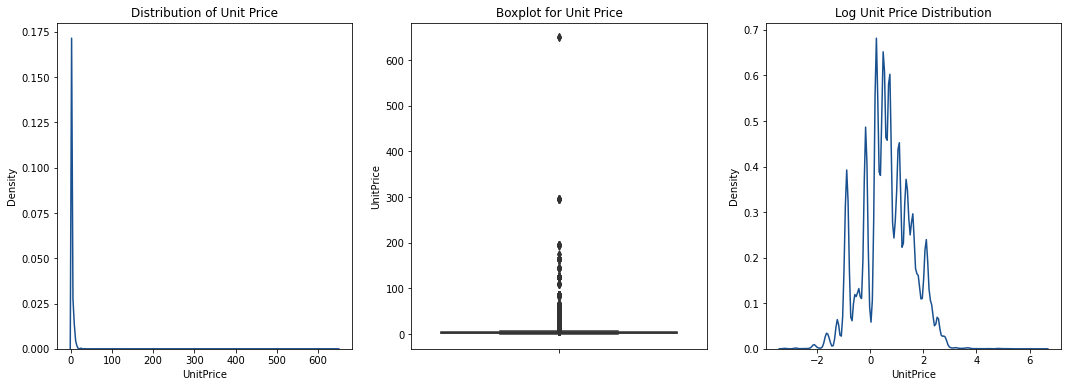

In [417]:
fig, axes = plt.subplots(1, 3, figsize = (18, 6))

sns.kdeplot(df["UnitPrice"], ax = axes[0], color = "#195190").set_title("Distribution of Unit Price")
sns.boxplot(y = df["UnitPrice"], ax = axes[1], color = "#195190").set_title("Boxplot for Unit Price")
sns.kdeplot(np.log(df["UnitPrice"]), ax = axes[2], color = "#195190").set_title("Log Unit Price Distribution")

plt.show()

In [418]:
print("Lower limit for UnitPrice: " + str(np.exp(-2)))
print("Upper limit for UnitPrice: " + str(np.exp(3)))

Lower limit for UnitPrice: 0.1353352832366127
Upper limit for UnitPrice: 20.085536923187668


In [419]:
df = df[(df.UnitPrice > 0.1) & (df.UnitPrice < 20)]

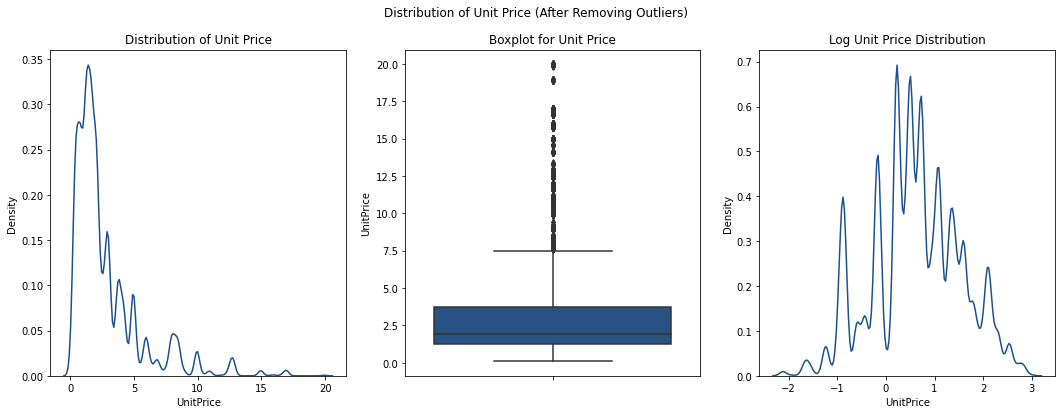

In [420]:
fig, axes = plt.subplots(1, 3, figsize = (18, 6))

sns.kdeplot(df["UnitPrice"], ax = axes[0], color = "#195190").set_title("Distribution of Unit Price")
sns.boxplot(y = df["UnitPrice"], ax = axes[1], color = "#195190").set_title("Boxplot for Unit Price")
sns.kdeplot(np.log(df["UnitPrice"]), ax = axes[2], color = "#195190").set_title("Log Unit Price Distribution")

fig.suptitle("Distribution of Unit Price (After Removing Outliers)")
plt.show()

From the below graphs we recognize the need to remove outliers from the data wrt to the Quantity column

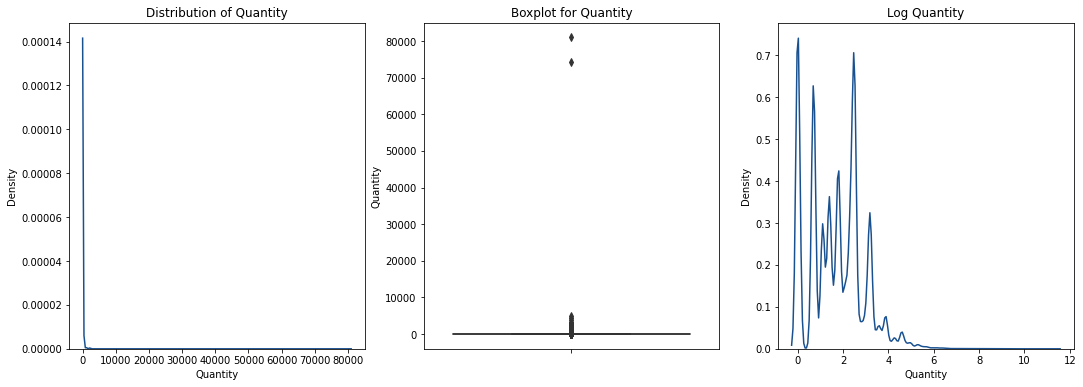

In [421]:
fig, axes = plt.subplots(1, 3, figsize = (18, 6))

sns.kdeplot(df["Quantity"], ax = axes[0], color = "#195190").set_title("Distribution of Quantity")
sns.boxplot(y = df["Quantity"], ax = axes[1], color = "#195190").set_title("Boxplot for Quantity")
sns.kdeplot(np.log(df["Quantity"]), ax = axes[2], color = "#195190").set_title("Log Quantity")
plt.show()

In [422]:
print("Upper limit for Quantity: " + str(np.exp(5)))

Upper limit for Quantity: 148.4131591025766


In [423]:
df = df[(df.Quantity < 150)]

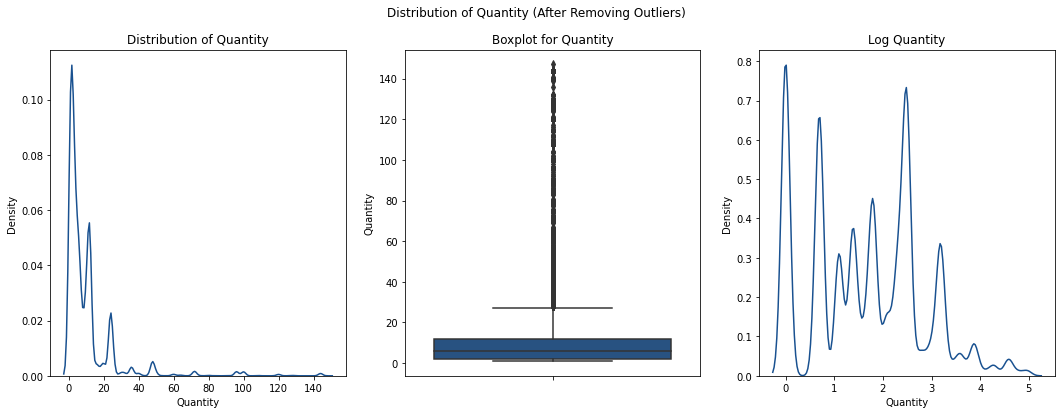

In [424]:
fig, axes = plt.subplots(1, 3, figsize = (18, 6))

sns.kdeplot(df["Quantity"], ax = axes[0], color = "#195190").set_title("Distribution of Quantity")
sns.boxplot(y = df["Quantity"], ax = axes[1], color = "#195190").set_title("Boxplot for Quantity")
sns.kdeplot(np.log(df["Quantity"]), ax = axes[2], color = "#195190").set_title("Log Quantity")

fig.suptitle("Distribution of Quantity (After Removing Outliers)")
plt.show()

In [425]:
df.shape

(387263, 9)

In [460]:
df.info()
df_lstm = df.copy()
df_arima = df.copy()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 387263 entries, 0 to 541908
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    387263 non-null  object        
 1   StockCode    387263 non-null  object        
 2   Description  387263 non-null  object        
 3   Quantity     387263 non-null  int64         
 4   InvoiceDate  387263 non-null  datetime64[ns]
 5   UnitPrice    387263 non-null  float64       
 6   CustomerID   387263 non-null  float64       
 7   Country      387263 non-null  object        
 8   Cancelled    387263 non-null  int64         
 9   TotalPrice   387263 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(4)
memory usage: 40.6+ MB


# Exploratory Data Analysis

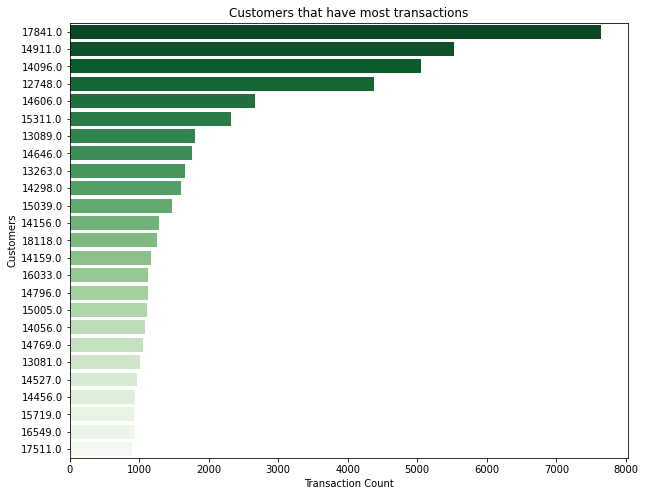

In [426]:
customer_counts = df.CustomerID.value_counts().sort_values(ascending=False).head(25)

fig, ax = plt.subplots(figsize = (10, 8))

sns.barplot(y = customer_counts.index, x = customer_counts.values, orient = "h", 
            ax = ax, order = customer_counts.index, palette = "Greens_r")

plt.title("Customers that have most transactions")
plt.ylabel("Customers")
plt.xlabel("Transaction Count")

plt.show()

From the below graph it can be concluded that not all customers purchase items in the same quantities, there are customers who purchase items more freequently than others in larger quantities

In [427]:
df.Country.value_counts()

United Kingdom          345860
Germany                   8593
France                    7972
EIRE                      6974
Spain                     2401
Netherlands               2025
Belgium                   1926
Switzerland               1806
Portugal                  1413
Australia                 1039
Norway                    1036
Italy                      739
Channel Islands            737
Finland                    645
Cyprus                     589
Austria                    380
Denmark                    364
Sweden                     353
Poland                     319
Japan                      300
Israel                     241
Unspecified                241
Singapore                  212
Iceland                    181
USA                        179
Canada                     147
Greece                     141
Malta                      109
United Arab Emirates        67
European Community          57
RSA                         57
Lebanon                     45
Lithuani

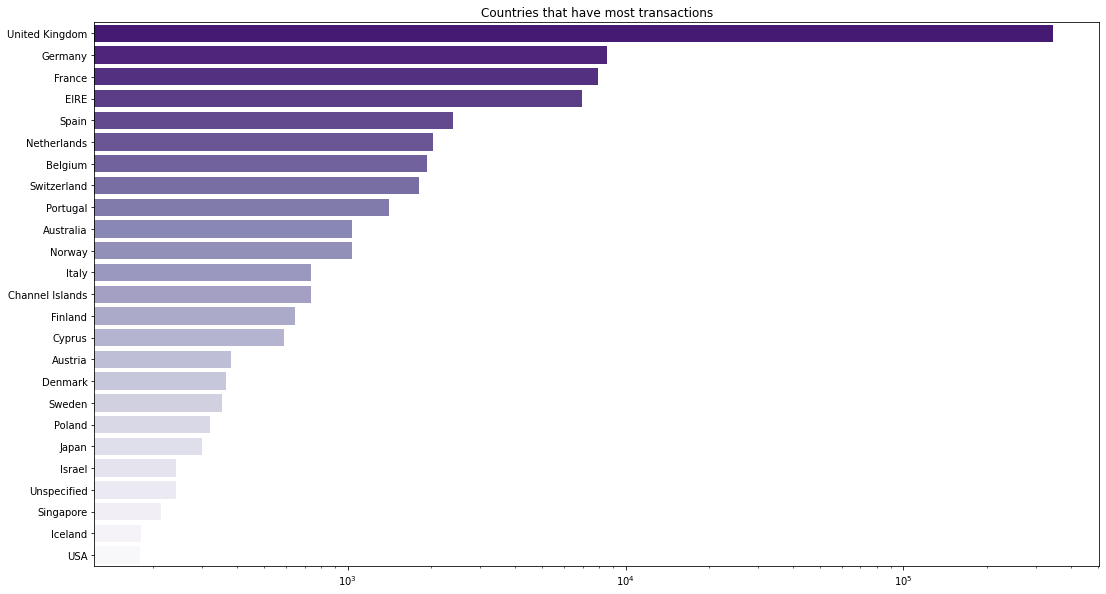

In [428]:
country_counts = df.Country.value_counts().sort_values(ascending=False).head(25)

fig, ax = plt.subplots(figsize = (18, 10))

sns.barplot(x = country_counts.values, y = country_counts.index, orient = "h", 
            ax = ax, order = country_counts.index, palette = "Purples_r")
plt.title("Countries that have most transactions")
plt.xscale("log")
plt.show()

In the previous count we concluded that a very large portion of the items sold were in the United Kingdom.

But when the number of transactions that take place in each country are calculated, the difference is not as much as expected.

This can be because most of the customers who purchase items in the United Kingdom buy multiple items in larger quantities than those of other countries who only utilize the services of the retail store to buy a few items in small quantites.

In [430]:
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

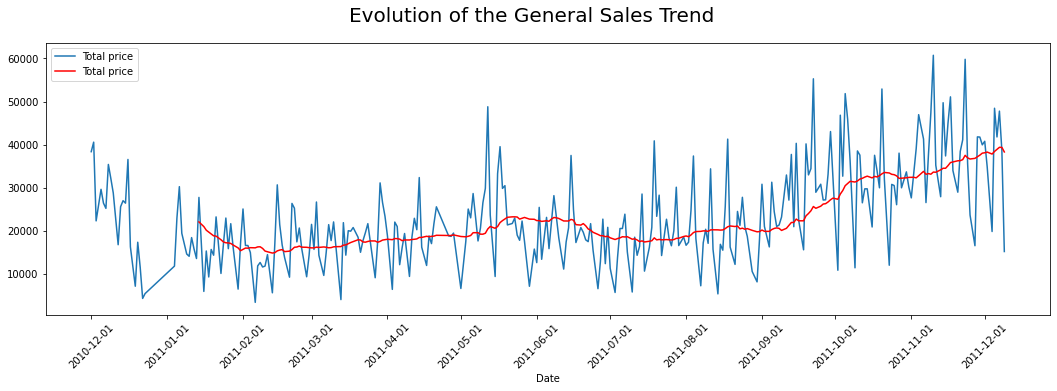

In [431]:
general_trend = pd.DataFrame(data={'Date':pd.to_datetime(df.InvoiceDate).dt.date, 'Total price':df.Quantity*df.UnitPrice})
general_trend = general_trend.groupby("Date")["Total price"].sum()
general_trend = pd.DataFrame(general_trend)
dates = []
dates.append(pd.to_datetime("201012",format="%Y%m"))
dates += [pd.to_datetime("2011"+str(month),format="%Y%m") for month in range(1,13)]
rolling_days = general_trend.copy()
rolling_days["Total price"] = rolling_days["Total price"].rolling(window=30).mean() 
plt.figure(figsize = (18,5)).suptitle('Evolution of the General Sales Trend', fontsize=20)
sns.lineplot(data=general_trend)
sns.lineplot(data=rolling_days, palette=['red'])
plt.xticks(dates,rotation = 45)
plt.show()

From the following graph it can be concluded that there is a rise in the sales of the online retail store towards the end of the year. This can perhaps be due to the arrival of festival season which causes teh expenditure to rise in every house old. 
People tend to buy presents for loved ones for Christmas as a result of which the sales rose significantly before the arrival of christmas.

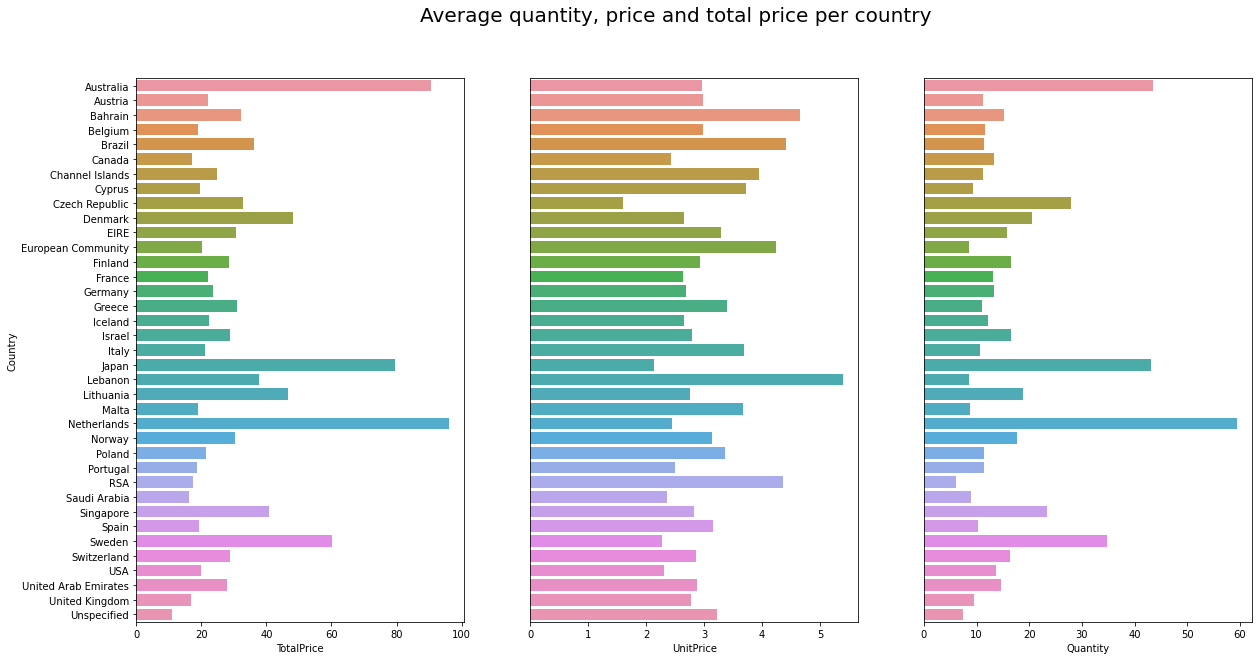

In [432]:
average_cart_countries = df.groupby("Country").TotalPrice.mean()
average_cart_countries = pd.DataFrame(average_cart_countries).reset_index()

average_price_countries = df.groupby("Country").UnitPrice.mean()
average_price_countries = pd.DataFrame(average_price_countries).reset_index()

average_quantity_countries = df.groupby("Country").Quantity.mean()
average_quantity_countries = pd.DataFrame(average_quantity_countries).reset_index()
fig = plt.figure(figsize = (20,10))
fig.suptitle("Average quantity, price and total price per country",size=20)

axes = fig.add_subplot(1, 3, 1)
sns.barplot(data=average_cart_countries,x="TotalPrice",y="Country")

axes = fig.add_subplot(1, 3, 2)
sns.barplot(data=average_price_countries,x="UnitPrice",y="Country")
fig.axes[1].get_yaxis().set_visible(False)

axes = fig.add_subplot(1, 3, 3)
sns.barplot(data=average_quantity_countries,x="Quantity",y="Country")
fig.axes[2].get_yaxis().set_visible(False)

Studying the following graphs it can be concluded that the people of Australia, Netherlands, Japan and Sweden tend to spend the most when it comes to purchasing products. This can perhaps be due to the fact that there are very few customers who make use of the store from these countries and has resulted in not proper company infratructure in these countries increasing the transportation cos


The people of the united kingdom despite having the largest number of customers tend to be on budget when it comes to purchasing products from the online retail store. This is perhaps due to the fact that the united kingdom was undergoing an economic slowdown during the time when this data was collected causing the people to cut back on spending in order to increase savings 

In [433]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 387263 entries, 0 to 541908
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    387263 non-null  object        
 1   StockCode    387263 non-null  object        
 2   Description  387263 non-null  object        
 3   Quantity     387263 non-null  int64         
 4   InvoiceDate  387263 non-null  datetime64[ns]
 5   UnitPrice    387263 non-null  float64       
 6   CustomerID   387263 non-null  float64       
 7   Country      387263 non-null  object        
 8   Cancelled    387263 non-null  int64         
 9   TotalPrice   387263 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(4)
memory usage: 40.6+ MB


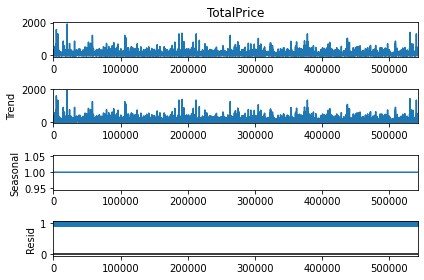

In [434]:
plt.rcParams["figure.figsize"]
sea_dec = seasonal_decompose(df["TotalPrice"], model = "multiplicative", extrapolate_trend='freq', period=1)
sea_dec.plot();

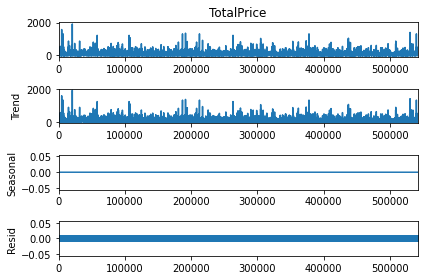

In [435]:
plt.rcParams["figure.figsize"]
sea_dec = seasonal_decompose(df["TotalPrice"], model = "additive", extrapolate_trend='freq', period=1)
sea_dec.plot();

# Apriori model Implementation

In [436]:
df.Country.unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Finland', 'Austria',
       'Sweden', 'Greece', 'Singapore', 'Lebanon', 'United Arab Emirates',
       'Israel', 'Saudi Arabia', 'Czech Republic', 'Canada',
       'Unspecified', 'Brazil', 'USA', 'European Community', 'Bahrain',
       'Malta', 'RSA'], dtype=object)

In [437]:
def hot_encode(x):
  if(x <= 0):
    return 0
  if(x >= 1):
    return 1

In [438]:
basket_overall = (df.groupby(['InvoiceNo', 'Description'])["Quantity"].sum().unstack().reset_index().fillna(0).set_index("InvoiceNo"))

In [439]:
basket_overall_encoded = basket_overall.applymap(hot_encode)

In [440]:
basket_overall_encoded.head()

Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [441]:
recurring_items_overall = apriori(basket_overall_encoded, min_support = 0.02, use_colnames = True) # building the model

In [442]:
as_rules_ov = association_rules(recurring_items_overall, metric = "lift", min_threshold = 1)
as_rules_ov = as_rules_ov.sort_values(["confidence", "lift"], ascending = [False, False])

In [443]:
print(as_rules_ov)

                                          antecedents  \
73  (ROSES REGENCY TEACUP AND SAUCER , PINK REGENC...   
74  (PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...   
9                    (PINK REGENCY TEACUP AND SAUCER)   
65                   (PINK REGENCY TEACUP AND SAUCER)   
13                  (GREEN REGENCY TEACUP AND SAUCER)   
..                                                ...   
20                          (JUMBO BAG RED RETROSPOT)   
18                          (JUMBO BAG RED RETROSPOT)   
68                         (REGENCY CAKESTAND 3 TIER)   
67               (WHITE HANGING HEART T-LIGHT HOLDER)   
10                         (REGENCY CAKESTAND 3 TIER)   

                            consequents  antecedent support  \
73    (GREEN REGENCY TEACUP AND SAUCER)            0.024051   
74   (ROSES REGENCY TEACUP AND SAUCER )            0.025436   
9     (GREEN REGENCY TEACUP AND SAUCER)            0.030756   
65   (ROSES REGENCY TEACUP AND SAUCER )            0.030756   


In [444]:
basket_uk = (df[df['Country'] == "United Kingdom"].groupby(['InvoiceNo', 'Description'])["Quantity"].sum().unstack().reset_index().fillna(0).set_index("InvoiceNo"))

In [445]:
basket_uk_encoded = basket_uk.applymap(hot_encode)

In [446]:
basket_uk_encoded.head()

Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,TOADSTOOL BEDSIDE LIGHT,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [447]:
recurring_items_uk = apriori(basket_uk_encoded, min_support = 0.02, use_colnames = True) # building the model

In [448]:
as_rules_uk = association_rules(recurring_items_uk, metric = "lift", min_threshold = 1)
as_rules_uk = as_rules_uk.sort_values(["confidence", "lift"], ascending = [False, False])

In [449]:
print(as_rules_uk)

                                          antecedents  \
72  (ROSES REGENCY TEACUP AND SAUCER , PINK REGENC...   
74  (GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY...   
4                    (PINK REGENCY TEACUP AND SAUCER)   
7                   (GREEN REGENCY TEACUP AND SAUCER)   
65                   (PINK REGENCY TEACUP AND SAUCER)   
..                                                ...   
16                          (JUMBO BAG RED RETROSPOT)   
14                          (JUMBO BAG RED RETROSPOT)   
68                         (REGENCY CAKESTAND 3 TIER)   
10                          (JUMBO BAG RED RETROSPOT)   
67               (WHITE HANGING HEART T-LIGHT HOLDER)   

                            consequents  antecedent support  \
72    (GREEN REGENCY TEACUP AND SAUCER)            0.023455   
74   (ROSES REGENCY TEACUP AND SAUCER )            0.024809   
4     (GREEN REGENCY TEACUP AND SAUCER)            0.030288   
7    (ROSES REGENCY TEACUP AND SAUCER )            0.037614   


In [450]:
basket_france = (df[df['Country'] == "France"].groupby(['InvoiceNo', 'Description'])["Quantity"].sum().unstack().reset_index().fillna(0).set_index("InvoiceNo"))

In [451]:
basket_france_encoded = basket_france.applymap(hot_encode)

In [452]:
basket_france_encoded.head()

Description,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,NINE DRAWER OFFICE TIDY,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,TRELLIS COAT RACK,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 EGG HOUSE PAINTED WOOD,...,WRAP SUKI AND FRIENDS,WRAP VINTAGE PETALS DESIGN,YELLOW COAT RACK PARIS FASHION,YELLOW GIANT GARDEN THERMOMETER,ZINC STAR T-LIGHT HOLDER,ZINC FOLKART SLEIGH BELLS,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536370,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536852,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536974,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
537065,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
537463,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [453]:
recurring_items_france = apriori(basket_france_encoded, min_support = 0.1, use_colnames = True) # building the model

In [454]:
as_rules_fr = association_rules(recurring_items_france, metric = "lift", min_threshold = 1)
as_rules_fr = as_rules_fr.sort_values(["confidence", "lift"], ascending = [False, False])

In [455]:
print(as_rules_fr)

                                          antecedents  \
11  (SET/6 RED SPOTTY PAPER CUPS, SET/20 RED RETRO...   
12  (SET/20 RED RETROSPOT PAPER NAPKINS , SET/6 RE...   
9                     (SET/6 RED SPOTTY PAPER PLATES)   
8                       (SET/6 RED SPOTTY PAPER CUPS)   
10  (SET/6 RED SPOTTY PAPER CUPS, SET/6 RED SPOTTY...   
6                     (SET/6 RED SPOTTY PAPER PLATES)   
14                    (SET/6 RED SPOTTY PAPER PLATES)   
3                          (PLASTERS IN TIN SPACEBOY)   
7               (SET/20 RED RETROSPOT PAPER NAPKINS )   
5               (SET/20 RED RETROSPOT PAPER NAPKINS )   
15              (SET/20 RED RETROSPOT PAPER NAPKINS )   
4                       (SET/6 RED SPOTTY PAPER CUPS)   
13                      (SET/6 RED SPOTTY PAPER CUPS)   
2                  (PLASTERS IN TIN WOODLAND ANIMALS)   
1                    (PLASTERS IN TIN CIRCUS PARADE )   
0                  (PLASTERS IN TIN WOODLAND ANIMALS)   

                              

# ARIMA model implimentation

In [461]:
df_arima.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 387263 entries, 0 to 541908
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    387263 non-null  object        
 1   StockCode    387263 non-null  object        
 2   Description  387263 non-null  object        
 3   Quantity     387263 non-null  int64         
 4   InvoiceDate  387263 non-null  datetime64[ns]
 5   UnitPrice    387263 non-null  float64       
 6   CustomerID   387263 non-null  float64       
 7   Country      387263 non-null  object        
 8   Cancelled    387263 non-null  int64         
 9   TotalPrice   387263 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(4)
memory usage: 40.6+ MB


In [462]:
df_arima["Total Sales"] = df_arima["Quantity"] * df_arima["UnitPrice"]
df_arima['InvoiceDate'] = pd.to_datetime(df_arima['InvoiceDate'])

In [463]:
df_arima.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 387263 entries, 0 to 541908
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    387263 non-null  object        
 1   StockCode    387263 non-null  object        
 2   Description  387263 non-null  object        
 3   Quantity     387263 non-null  int64         
 4   InvoiceDate  387263 non-null  datetime64[ns]
 5   UnitPrice    387263 non-null  float64       
 6   CustomerID   387263 non-null  float64       
 7   Country      387263 non-null  object        
 8   Cancelled    387263 non-null  int64         
 9   TotalPrice   387263 non-null  float64       
 10  Total Sales  387263 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(2), object(4)
memory usage: 43.5+ MB


In [464]:
del df_arima["InvoiceNo"]
del df_arima["StockCode"]
del df_arima["Description"]
del df_arima["Quantity"]
del df_arima["UnitPrice"]
del df_arima["CustomerID"]
del df_arima["Country"]
del df_arima["Cancelled"]

In [465]:
df_arima.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 387263 entries, 0 to 541908
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceDate  387263 non-null  datetime64[ns]
 1   TotalPrice   387263 non-null  float64       
 2   Total Sales  387263 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 19.9 MB


In [466]:
df_arima['Year']=df_arima.InvoiceDate.dt.year
df_arima['Month']=df_arima.InvoiceDate.dt.month
df_arima['Week']=df_arima.InvoiceDate.dt.week
df_arima['Day']=df_arima.InvoiceDate.dt.day

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [467]:
df_arima.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 387263 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceDate  387263 non-null  datetime64[ns]
 1   TotalPrice   387263 non-null  float64       
 2   Total Sales  387263 non-null  float64       
 3   Year         387263 non-null  int64         
 4   Month        387263 non-null  int64         
 5   Week         387263 non-null  int64         
 6   Day          387263 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(4)
memory usage: 31.7 MB


In [468]:
del df_arima["Year"]
del df_arima["Month"]
del df_arima["Day"]
del df_arima["InvoiceDate"]

In [469]:
df_arima.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 387263 entries, 0 to 541908
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   TotalPrice   387263 non-null  float64
 1   Total Sales  387263 non-null  float64
 2   Week         387263 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 19.9 MB


In [470]:
df_arima = df_arima.groupby("Week").sum()

In [471]:
df_arima.head()

,TotalPrice,Total Sales
Week,,
1,99099.94,99099.94
2,95692.88,95692.88
3,88100.48,88100.48
4,100002.67,100002.67
5,93959.88,93959.88


In [472]:
df_arima.tail()

,TotalPrice,Total Sales
Week,,
47,215336.00,215336.00
48,349951.86,349951.86
49,356707.49,356707.49
50,139105.08,139105.08
51,38756.34,38756.34


In [473]:
def adf_test(Time_Series, check = 0.05):
    adf_test = adfuller(Time_Series, autolag = "AIC")
    print(f"H0: {Time_Series.name} is a on-stationary time series")
    print(f"H1: {Time_Series.name} is stationary time series")
    test_adf = adf_test[0]; print(f"ADF test statistic: {adf_test[0]}")
    value_p = adf_test[1]; print(f"p-value: {adf_test[1]}")
    print(f"Lags: {adf_test[2]}")    
    print("Critical Values : ")
    for key, item in adf_test[4].items(): print("\t", key, "\t", item)
    print(f"\nFor {check} significance level: \n")
    if value_p< check:
        print("We reject null hypothesis, series is stationary.")
    else:
        print("We can not reject null hypothesis, it is plausible that teh series is non-stationary")

In [474]:
print("On performing ADF we get: ")
adf_test(df_arima["Total Sales"])

On performing ADF we get: 
H0: Total Sales is a on-stationary time series
H1: Total Sales is stationary time series
ADF test statistic: -0.7272851268735697
p-value: 0.8395549338563533
Lags: 3
Critical Values : 
	 1% 	 -3.5778480370438146
	 5% 	 -2.925338105429433
	 10% 	 -2.6007735310095064

For 0.05 significance level: 

We can not reject null hypothesis, it is plausible that teh series is non-stationary


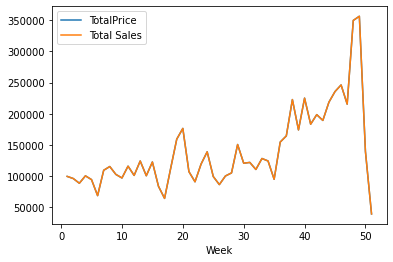

In [475]:
df_arima.plot()

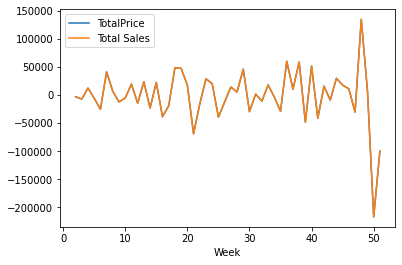

In [476]:
diff_model = df_arima.diff()
diff_model.plot()

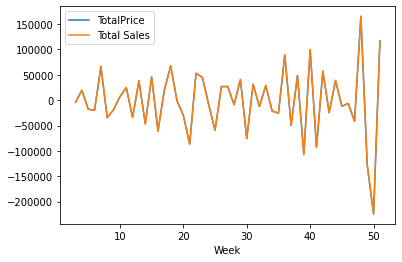

In [477]:
diff_model_2 = df_arima.diff().diff()
diff_model_2.plot()

In [478]:
df_arima.describe()

,TotalPrice,Total Sales
count,51.000000,51.000000
mean,139769.062941,139769.062941
std,64624.369225,64624.369225
min,38756.340000,38756.340000
25%,99440.490000,99440.490000
50%,118958.130000,118958.130000
75%,169046.900000,169046.900000
max,356707.490000,356707.490000


In [479]:
time_series = df_arima["Total Sales"]

In [480]:
type(time_series)

pandas.core.series.Series

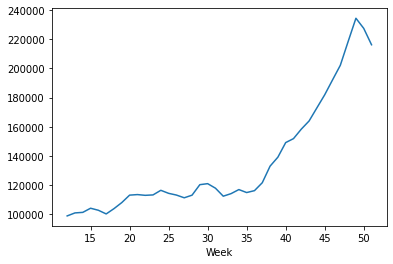

In [481]:
time_series.rolling(12).mean().plot()

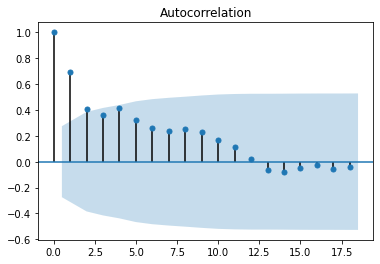

In [482]:
plot_acf(time_series);

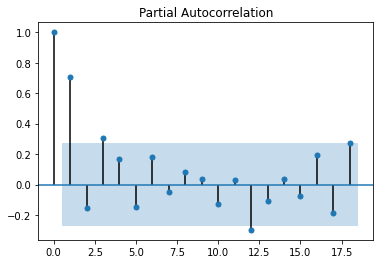

In [483]:
plot_pacf(time_series);

In [484]:
train_arima = df_arima[:45]
test_arima = df_arima[45:]

In [485]:
model_arima = ARIMA(train_arima["Total Sales"], order = (2, 1, 0))
model_arima = model_arima.fit()
model_arima.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecastin

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:          D.Total Sales   No. Observations:                   44
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -513.693
Method:                       css-mle   S.D. of innovations          28415.304
Date:                Fri, 11 Nov 2022   AIC                           1035.385
Time:                        08:53:28   BIC                           1042.522
Sample:                             1   HQIC                          1038.032
                                                                              
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                3023.4203   3045.647      0.993      0.321   -2945.939    8992.779
ar.L1.D.Total Sales    -0.3154      0.150     -2.109      0.035      -0.609      -0.022
ar.L2.D.Total Sales    -0.1032      0.149     -0.692      0.489      -0.396       0.189
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.5273           -2.7116j            3.1121           -0.3316
AR.2           -1.5273           +2.7116j            3.1121            0.3316
-----------------------------------------------------------------------------
"""

In [486]:
start = len(train_arima)
end = len(train_arima)+len(test_arima)-1
pred = model_arima.predict(start = start, end = end, typ = "levels")
print(pred)
pred.index = df_arima.index[start:end+1]

44    231432.498232
45    235260.453015
46    238769.404059
47    241556.624609
48    244604.409673
49    247644.532928
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


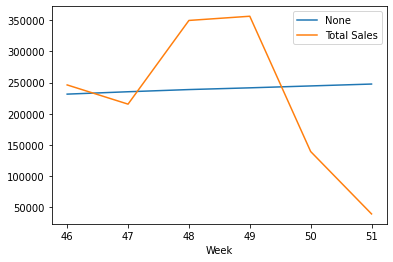

In [487]:
pred.plot(legend = True)
test_arima["Total Sales"].plot(legend = True)

# LSTM model implimentation

In [488]:
df_lstm['InvoiceDate'] = pd.to_datetime(df_lstm['InvoiceDate'])
df_lstm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 387263 entries, 0 to 541908
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    387263 non-null  object        
 1   StockCode    387263 non-null  object        
 2   Description  387263 non-null  object        
 3   Quantity     387263 non-null  int64         
 4   InvoiceDate  387263 non-null  datetime64[ns]
 5   UnitPrice    387263 non-null  float64       
 6   CustomerID   387263 non-null  float64       
 7   Country      387263 non-null  object        
 8   Cancelled    387263 non-null  int64         
 9   TotalPrice   387263 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(4)
memory usage: 40.6+ MB


In [489]:
df_lstm['Sales'] = df_lstm.Quantity*df_lstm.UnitPrice
df_lstm['Year']=df_lstm.InvoiceDate.dt.year
df_lstm['Month']=df_lstm.InvoiceDate.dt.month
df_lstm['Week']=df_lstm.InvoiceDate.dt.week
df_lstm['Day']=df_lstm.InvoiceDate.dt.day

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  after removing the cwd from sys.path.


In [490]:
df_lstm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 387263 entries, 0 to 541908
Data columns (total 15 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    387263 non-null  object        
 1   StockCode    387263 non-null  object        
 2   Description  387263 non-null  object        
 3   Quantity     387263 non-null  int64         
 4   InvoiceDate  387263 non-null  datetime64[ns]
 5   UnitPrice    387263 non-null  float64       
 6   CustomerID   387263 non-null  float64       
 7   Country      387263 non-null  object        
 8   Cancelled    387263 non-null  int64         
 9   TotalPrice   387263 non-null  float64       
 10  Sales        387263 non-null  float64       
 11  Year         387263 non-null  int64         
 12  Month        387263 non-null  int64         
 13  Week         387263 non-null  int64         
 14  Day          387263 non-null  int64         
dtypes: datetime64[ns](1), float64(4), 

In [491]:
print(df_lstm)

       InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  UnitPrice  CustomerID         Country  Cancelle

In [492]:
len(df_lstm)

387263

In [493]:
del df_lstm["InvoiceNo"]
del df_lstm["StockCode"]
del df_lstm["Description"]
del df_lstm["Quantity"]
del df_lstm["InvoiceDate"]
del df_lstm["UnitPrice"]
del df_lstm["CustomerID"]
del df_lstm["Country"]
del df_lstm["Cancelled"]
del df_lstm["TotalPrice"]
del df_lstm["Year"]
del df_lstm["Month"]
del df_lstm["Day"]

In [494]:
df_lstm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 387263 entries, 0 to 541908
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Sales   387263 non-null  float64
 1   Week    387263 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 16.9 MB


In [495]:
df_lstm = df_lstm.groupby("Week").sum()

In [496]:
df_lstm

,Sales
Week,
1,99099.94
2,95692.88
3,88100.48
4,100002.67
5,93959.88
6,68177.18
7,108938.14
8,114981.07
9,102303.64


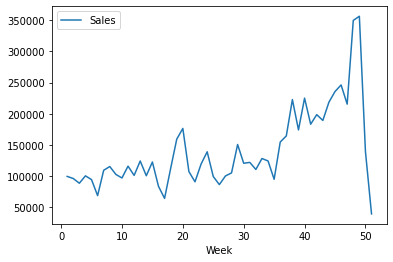

In [497]:
df_lstm.plot()

In [498]:
df_lstm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51 entries, 1 to 51
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   51 non-null     float64
dtypes: float64(1)
memory usage: 816.0 bytes


In [499]:
train = df_lstm.iloc[:45]
test = df_lstm.iloc[45:]

In [500]:
scaler = MinMaxScaler()

In [501]:
df_lstm.head()

,Sales
Week,
1,99099.94
2,95692.88
3,88100.48
4,100002.67
5,93959.88


In [502]:
df_lstm.tail()

,Sales
Week,
47,215336.00
48,349951.86
49,356707.49
50,139105.08
51,38756.34


In [503]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [504]:
scaled_train[:10]

array([[0.20589657],
       [0.18607116],
       [0.1418916 ],
       [0.21114948],
       [0.17598697],
       [0.02595954],
       [0.26314425],
       [0.29830757],
       [0.22453864],
       [0.1910834 ]])

In [505]:
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length = n_input, batch_size = 1)

In [506]:
model = Sequential()
model.add(LSTM(200, activation = 'relu', input_shape = (n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer = "adam", loss = "mse")

In [507]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 200)               161600    
                                                                 
 dense_3 (Dense)             (None, 1)                 201       
                                                                 
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [522]:
model.fit(generator, epochs = 300)

Epoch 1/300
42/42 [==============================] - 0s 7ms/step - loss: 0.0110
Epoch 2/300
42/42 [==============================] - 0s 6ms/step - loss: 0.0097
Epoch 3/300
42/42 [==============================] - 0s 5ms/step - loss: 0.0097
Epoch 4/300
42/42 [==============================] - 0s 6ms/step - loss: 0.0097
Epoch 5/300
42/42 [==============================] - 0s 6ms/step - loss: 0.0097
Epoch 6/300
42/42 [==============================] - 0s 6ms/step - loss: 0.0109
Epoch 7/300
42/42 [==============================] - 0s 6ms/step - loss: 0.0119
Epoch 8/300
42/42 [==============================] - 0s 6ms/step - loss: 0.0092
Epoch 9/300
42/42 [==============================] - 0s 6ms/step - loss: 0.0086
Epoch 10/300
42/42 [==============================] - 0s 6ms/step - loss: 0.0097
Epoch 11/300
42/42 [==============================] - 0s 6ms/step - loss: 0.0097
Epoch 12/300
42/42 [==============================] - 0s 6ms/step - loss: 0.0096
Epoch 13/300
42/42 [=================

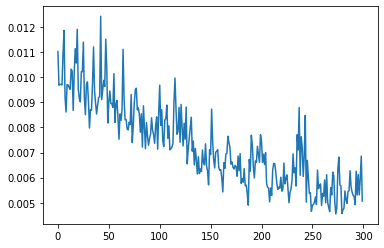

In [523]:
loss_per_epoch = model.history.history["loss"]
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [524]:
last_train_batch = scaled_train[-3:]

In [525]:
last_train_batch

array([[0.72961864],
       [0.90047921],
       [1.        ]])

In [526]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [527]:
last_train_batch

array([[[0.72961864],
        [0.90047921],
        [1.        ]]])

In [528]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 21ms/step


array([[1.1121851]], dtype=float32)

In [529]:
scaled_test[0]

array([1.06196043])

In [530]:
test_predictions = []
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape(1, n_input, n_features)

In [531]:
for i in range(len(test)):
  current_pred = model.predict(current_batch)[0]
  test_predictions.append(current_pred)
  current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis = 1)

1/1 [==============================] - 0s 21ms/step


In [532]:
test_predictions

[array([1.1121851], dtype=float32),
 array([1.2826427], dtype=float32),
 array([1.4482921], dtype=float32),
 array([1.5603217], dtype=float32),
 array([1.6039938], dtype=float32),
 array([1.5236397], dtype=float32)]

In [533]:
true_predictions = scaler.inverse_transform(test_predictions)

In [534]:
test["Predictions"] = true_predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


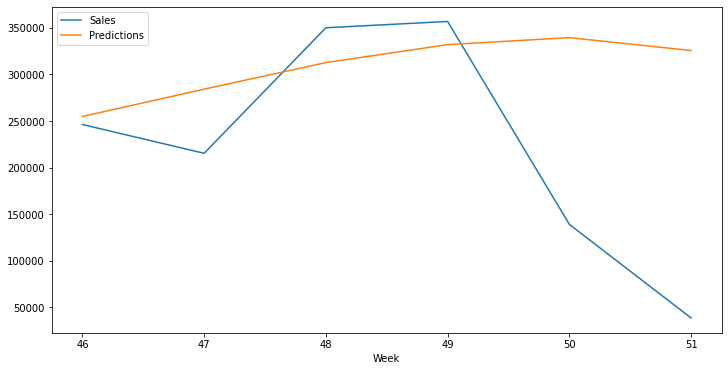

In [535]:
test.plot(figsize = (12,6))

In [536]:
rmse = sqrt(mean_squared_error(test["Sales"], test["Predictions"]))

In [537]:
print(rmse)

146731.57995924787
